In [2]:
import pandas as pd
import numpy as np
import os
from utils.img_processing import save_npy, split_train_test
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.utils import qth_survival_time
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy import ndimage
import time
import copy
from utils.T1Dataset import T1Dataset
from utils.img_processing import save_npy,read_npy,gaussian_prob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils import data
import torch.nn.functional as F
from torch.optim import lr_scheduler
from models.CNN_model import Net1
from models.resnet_model import Resnet
from utils.unetloss import Meter,BCEDiceLoss
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [6]:
def choose_dead_patient(df, WHO_value = 4):
    df1 = df[(df['status_dead'] == 1) & (df['WHO'] > WHO_value - 1)]
    return df1

In [7]:
TCGA = pd.read_csv('/root/autodl-tmp/MR_csv/glioma_survival_time_TCGA.csv')
TCGA_  = choose_dead_patient(TCGA, WHO_value=3)

In [9]:
train_img, train_mask, train_label, test_img, test_mask, test_label = split_train_test(img_dir, mask_dir, label)
save_path = '/root/autodl-tmp/MR_csv/glioma_survive'
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_train_img.npy'), train_img)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_train_mask.npy'), train_mask)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_train_label.npy'), train_label)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_test_img.npy'), test_img)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_test_mask.npy'), test_mask)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_test_label.npy'), test_label)

NameError: name 'img_dir' is not defined

In [7]:
huashan = pd.read_csv('/root/autodl-tmp/MR_csv/glioma_survival_time_Huashan.csv')
huashan_  = choose_dead_patient(huashan, WHO_value=3)
base_dir = '/root/autodl-tmp/glioma_Huashan'
img_dir, mask_dir, label = [], [], []
for name in huashan_['name']:
    current_dir = os.path.join(base_dir, name + '_T1_CE_1mm')
    for file in os.listdir(current_dir):
        sub_dir = os.path.join(current_dir, file)
        if 'correct' in file:
            img_dir.append(sub_dir)
        elif 'label' in file:
            mask_dir.append(sub_dir)
    day = huashan_[huashan_['name'] == name]['survival_day'].values.squeeze().tolist()/365
    label.append(day)


In [8]:
len(img_dir), len(mask_dir), len(label)

(84, 84, 84)

In [ ]:
def normalize_array(array):
    min_value = np.min(array)
    max_value = np.max(array)
    normalized_array = (array - min_value) / (max_value - min_value)
    return normalized_array
data = pd.read_csv('/root/autodl-tmp/MR_csv/IDH/gene_TCGA_information.csv')
X = data['TOX2'].values
X_processing = normalize_array(X)
data['TOX2'] = X_processing
data.drop_duplicates('name', inplace=True)
for mean in data['TOX2']:
   x=np.arange(0,1.2,0.1)
   y = gaussian_prob(x,mean,0.2)
   plt.plot(x,y)
   plt.show()

In [12]:
data

,name,TOX2,survival_day,status_dead
0,TCGA-02-0047,0.641640,448.0,1.0
1,TCGA-06-0129,0.748673,1024.0,1.0
2,TCGA-06-0130,0.436552,394.0,1.0
3,TCGA-06-0138,0.374542,737.0,1.0
4,TCGA-06-0139,0.180284,362.0,1.0
...,...,...,...,...
106,TCGA-DU-5854,0.621363,252.0,0.0
107,TCGA-DU-6397,0.478810,1380.0,1.0
109,TCGA-DU-6410,0.646180,240.0,0.0
110,TCGA-DU-7010,0.722547,450.0,1.0


In [70]:
train_img, train_mask, train_label, test_img, test_mask, test_label = split_train_test(img_dir, mask_dir, label)
save_path = '/root/autodl-tmp/MR_csv/glioma_survive'
save_npy(os.path.join(save_path,'WHO4_glioma_huashan_train_img.npy'), train_img)
save_npy(os.path.join(save_path,'WHO4_glioma_huashan_train_mask.npy'), train_mask)
save_npy(os.path.join(save_path,'WHO4_glioma_huashan_train_label.npy'), train_label)
save_npy(os.path.join(save_path,'WHO4_glioma_huashan_test_img.npy'), test_img)
save_npy(os.path.join(save_path,'WHO4_glioma_huashan_test_mask.npy'), test_mask)
save_npy(os.path.join(save_path,'WHO4_glioma_huashan_test_label.npy'), test_label)

In [13]:
# 回归模型估计
checkpoint = torch.load('/root/autodl-tmp/MR_csv/glioma_survive/best_model1_cnn_predict_day_WHO_4.pth')
train_img = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_TCGA_train_img.npy')
train_mask = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_TCGA_train_mask.npy')
train_label = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_TCGA_train_label.npy')
test_img = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_TCGA_test_img.npy')
test_mask = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_TCGA_test_mask.npy')
test_label = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_TCGA_test_label.npy')

    # 建立dataload er
train_ds = T1Dataset(train_img,train_mask, train_label)
test_ds = T1Dataset(test_img,test_mask, test_label)


train_dl = DataLoader(
                        train_ds,
                        shuffle=True,
                        batch_size = 8,
    )
test_dl = DataLoader(
                        test_ds,
                        batch_size = 8,
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
criterion= nn.MSELoss()
'''F.binary_cross_entropy_with_logits'''
model = Net1()
model.to(device)
# dir1 = '/root/autodl-tmp/seriouscheckpoint1.pth'
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [76]:
# 回归模型估计
checkpoint = torch.load('/root/autodl-tmp/MR_csv/glioma_survive/best_model1_cnn_predict_day_WHO_4.pth')
train_img = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_huashan_train_img.npy')
train_mask = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_huashan_train_mask.npy')
train_label = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_huashan_train_label.npy')
test_img = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_huashan_test_img.npy')
test_mask = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_huashan_test_mask.npy')
test_label = read_npy('/root/autodl-tmp/MR_csv/glioma_survive/WHO4_glioma_huashan_test_label.npy')
    # 建立dataload er
train_ds = T1Dataset(train_img,train_mask, train_label)
test_ds = T1Dataset(test_img,test_mask, test_label)


train_dl = DataLoader(
                        train_ds,
                        shuffle=True,
                        batch_size = 8,
    )
test_dl = DataLoader(
                        test_ds,
                        batch_size = 8,
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
criterion= nn.MSELoss()
'''F.binary_cross_entropy_with_logits'''
model = Net1()
model.to(device)
# dir1 = '/root/autodl-tmp/seriouscheckpoint1.pth'
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [77]:
model.eval()
with torch.no_grad():
    for itr, (images, day) in enumerate(test_dl):
        images = images.to(device)
        risk_score = model(images.float()).squeeze()
        event = torch.tensor(1)
        print(day)
        if itr == 0:
            deep_score_test = risk_score.cpu()
            survival_day_test = day
        else:
            deep_score_test = torch.cat((deep_score_test, risk_score.cpu()),0)
            survival_day_test = torch.cat((survival_day_test, day), 0)
    for itr, (images, day) in enumerate(train_dl):
        images = images.to(device)
        risk_score = model(images.float()).squeeze()
        if itr == 0:
            deep_score_train = risk_score.cpu()
            survival_day_train = day
        else:
            deep_score_train = torch.cat((deep_score_train, risk_score.cpu()),0)
            survival_day_train = torch.cat((survival_day_train, day), 0)
event_test = torch.ones_like(survival_day_test)
event_train = torch.ones_like(survival_day_train)
state = {
    'survival_day': survival_day_train,
    'status_dead': event_train,
    'predict_survival_day': deep_score_train.detach().numpy()
}
train = pd.DataFrame(state)
state_test = {
    'survival_day': survival_day_test,
    'status_dead': event_test,
    'predict_survival_day': deep_score_test.detach().numpy()
}
test = pd.DataFrame(state_test)
df1 = pd.concat([train, test])

tensor([2.1644, 1.1699, 0.3315, 0.9096, 0.8932, 0.0767, 2.7699, 0.4548, 0.9370,
        1.2877, 1.0575, 2.7452, 1.0110, 2.2137, 1.0274, 1.2219, 0.6904],
       dtype=torch.float64)


In [9]:
model.eval()
with torch.no_grad():
    for itr, (images, day) in enumerate(test_dl):
        images = images.to(device)
        risk_score = model(images.float()).squeeze()
        event = torch.tensor(1)
        if itr == 0:
            deep_score_test = risk_score.cpu()
            survival_day_test = day
        else:
            deep_score_test = torch.cat((deep_score_test, risk_score.cpu()),0)
            survival_day_test = torch.cat((survival_day_test, day), 0)
    for itr, (images, day) in enumerate(train_dl):
        images = images.to(device)
        risk_score = model(images.float()).squeeze()
        if itr == 0:
            deep_score_train = risk_score.cpu()
            survival_day_train = day
        else:
            deep_score_train = torch.cat((deep_score_train, risk_score.cpu()),0)
            survival_day_train = torch.cat((survival_day_train, day), 0)
event_test = torch.ones_like(survival_day_test)
event_train = torch.ones_like(survival_day_train)
state = {
    'survival_day': survival_day_train,
    'status_dead': event_train,
    'predict_survival_day': deep_score_train.detach().numpy()
}
train = pd.DataFrame(state)
state_test = {
    'survival_day': survival_day_test,
    'status_dead': event_test,
    'predict_survival_day': deep_score_test.detach().numpy()
}
test = pd.DataFrame(state_test)
df = pd.concat([train, test])
df.to_csv(os.path.join('/root/autodl-tmp/MR_csv/glioma_survive', 'CNN_predict_survival_score.csv')) # 改路径

Text(0.5, 1.0, 'KM_curve')

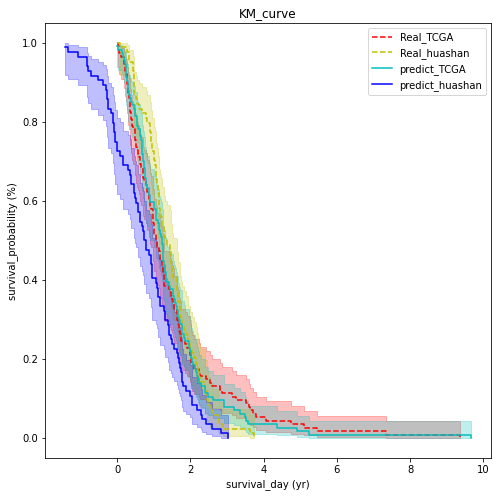

In [86]:
plt.figure(figsize=(8,8))
kmf = KaplanMeierFitter()
kmf.fit(TCGA_["survival_day"]/365, TCGA_["status_dead"], label='Real_TCGA')
kmf.plot_survival_function(color = 'r',linestyle='dashed')
kmf.fit(huashan_["survival_day"]/365, huashan_["status_dead"], label='Real_huashan')
kmf.plot_survival_function(color = 'y',linestyle='dashed')
kmf.fit(df["predict_survival_day"], df["status_dead"], label='predict_TCGA')
kmf.plot_survival_function(color = 'c')
kmf.fit(df1["predict_survival_day"], df1["status_dead"], label='predict_huashan')
kmf.plot_survival_function(color = 'b')
plt.xlabel('survival_day (yr)')
plt.ylabel('survival_probability (%)')
plt.title('KM_curve')

In [88]:
pd.read_csv('/root/autodl-tmp/MR_csv/glioma_survive/CNN_risk_score1.csv')

,Unnamed: 0,name,survival_day,status,risk
0,0,TCGA-HT-7854,3.246575,0,-2.158190
1,1,Shi_Yan_Bing,0.690411,1,1.709278
2,2,TCGA-HT-8012,0.772603,0,-1.054479
3,3,TCGA-08-0350,2.435616,1,0.271837
4,4,Yang_Hong_Fei,4.758904,0,-2.520201
...,...,...,...,...,...
409,78,TCGA-HT-7881,0.238356,0,-1.779780
410,79,Chen_Ji_Chong,3.756164,0,-0.004113
411,80,TCGA-08-0353,0.701370,1,0.960039
412,81,TCGA-HT-7877,0.008219,0,-1.286174


In [35]:
train_img, train_mask, train_label, test_img, test_mask, test_label = split_train_test(img_dir, mask_dir, label)
save_path = '/root/autodl-tmp/MR_csv/glioma_survive'
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_train_img.npy'), train_img)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_train_mask.npy'), train_mask)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_train_label.npy'), train_label)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_test_img.npy'), test_img)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_test_mask.npy'), test_mask)
save_npy(os.path.join(save_path,'WHO4_glioma_TCGA_test_label.npy'), test_label)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
num_samples = 1000
input_size = 64
num_keypoints = 5

# 生成随机图像作为输入数据
input_data = torch.randn(num_samples, 1, input_size, input_size)

# 生成随机关键点位置
keypoint_coords = torch.randint(low=0, high=input_size, size=(num_samples, num_keypoints, 2)).float()

# 生成对应的热力图
heatmap = torch.zeros(num_samples, num_keypoints, input_size, input_size)
for i in range(num_samples):
    for j in range(num_keypoints):
        x, y = keypoint_coords[i, j]
        heatmap[i, j, int(x), int(y)] = 1


In [18]:
data = pd.read_csv('/root/autodl-tmp/MR_csv/IDH/gene_TCGA_information.csv')
data['TOX2']

0       8.962896
1       9.903882
2       7.159871
3       6.614710
4       4.906891
         ...    
107     7.531381
108     7.434628
109     9.002815
110     9.674192
111    10.732167
Name: TOX2, Length: 112, dtype: float64

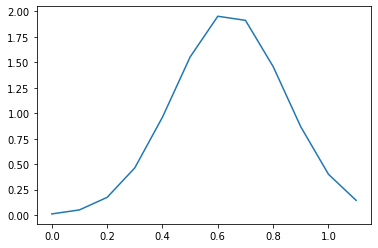

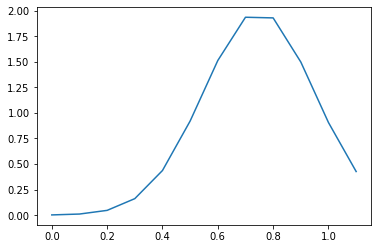

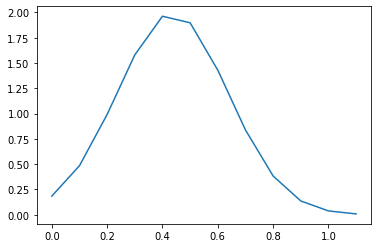

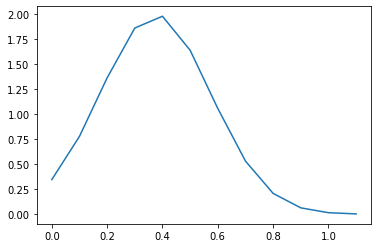

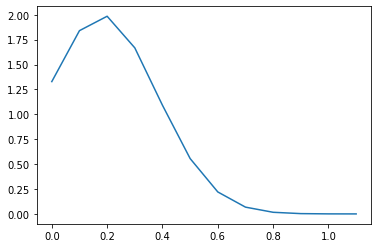

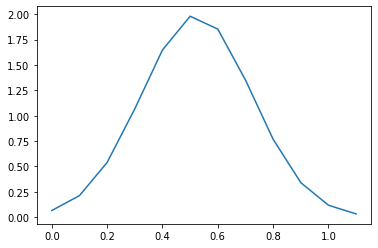

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [11]:
def normalize_array(array):
    min_value = np.min(array)
    max_value = np.max(array)
    normalized_array = (array - min_value) / (max_value - min_value)
    return normalized_array
data = pd.read_csv('/root/autodl-tmp/MR_csv/IDH/gene_TCGA_information.csv')
X = data['TOX2'].values
X_processing = normalize_array(X)
data['TOX2'] = X_processing
data.drop_duplicates('name', inplace=True)
for mean in data['TOX2']:
   x=np.arange(0,1.2,0.1)
   y = gaussian_prob(x,mean,0.2)


,name,TOX2,survival_day,status_dead
0,TCGA-02-0047,0.641640,448.0,1.0
1,TCGA-06-0129,0.748673,1024.0,1.0
2,TCGA-06-0130,0.436552,394.0,1.0
3,TCGA-06-0138,0.374542,737.0,1.0
4,TCGA-06-0139,0.180284,362.0,1.0
...,...,...,...,...
106,TCGA-DU-5854,0.621363,252.0,0.0
107,TCGA-DU-6397,0.478810,1380.0,1.0
109,TCGA-DU-6410,0.646180,240.0,0.0
110,TCGA-DU-7010,0.722547,450.0,1.0


In [3]:
def normalize_array(array):
    min_value = np.min(array)
    max_value = np.max(array)
    normalized_array = (array - min_value) / (max_value - min_value)
    return normalized_array
data = pd.read_csv('/root/autodl-tmp/MR_csv/IDH/gene_TCGA_information.csv')
X = data['TOX2'].values
X_processing = normalize_array(X)
data['TOX2'] = X_processing
data.drop_duplicates('name', inplace=True)
base_dir = '/root/autodl-tmp/glioma_T1_information'
img_dir, mask_dir, label = [], [], []
for name in data['name']:
    current_dir = os.path.join(base_dir, name + '_T1_CE_1mm')
    for file in os.listdir(current_dir):
        sub_dir = os.path.join(current_dir, file)
        if 'correct' in file:
            img_dir.append(sub_dir)
        elif 'label' in file:
            mask_dir.append(sub_dir)
    day = data[data['name'] == name]['TOX2'].values.squeeze().tolist()
    x=np.arange(0,1.2,0.1)
    y = gaussian_prob(x,day,0.2)
    label.append(y)

In [10]:
len(label)

108

In [11]:
train_img, train_mask, train_label, test_img, test_mask, test_label = split_train_test(img_dir, mask_dir, label)
save_path = '/root/autodl-tmp/MR_csv/IDH'
save_npy(os.path.join(save_path,'glioma_TCGA_train_img.npy'), train_img)
save_npy(os.path.join(save_path,'glioma_TCGA_train_mask.npy'), train_mask)
save_npy(os.path.join(save_path,'glioma_TCGA_train_label.npy'), train_label)
save_npy(os.path.join(save_path,'glioma_TCGA_test_img.npy'), test_img)
save_npy(os.path.join(save_path,'glioma_TCGA_test_mask.npy'), test_mask)
save_npy(os.path.join(save_path,'glioma_TCGA_test_label.npy'), test_label)